In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [13]:
np.random.seed(420)

# Remember, the coefficients for AR part are negative of intended!
arma_22 = ArmaProcess(ar = np.array([1, -0.33, -0.5]),
            ma = np.array([1, 0.9, 0.3])).generate_sample(10000)

Text(0.5, 1.0, 'ARMA(2, 2) process')

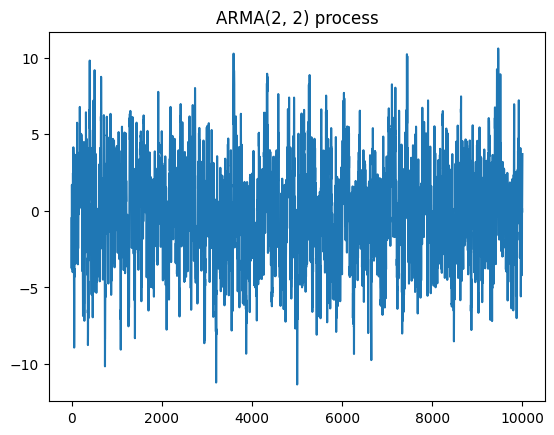

In [14]:
fig, ax = plt.subplots()
ax.plot(arma_22)
ax.set_title("ARMA(2, 2) process")

In [16]:
adfuller(arma_22)[0:2]
# Stationary!

(-20.037298431089546, 0.0)

In [17]:
df = pd.DataFrame({"Value":arma_22})
training = df[:800]
testing = df[800:]

In [24]:
p_ranges = np.arange(0, 5)
q_ranges = np.arange(0, 5)

grid_pq = list(product(p_ranges, q_ranges))
grid_pq

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [31]:
def optimize_ARMA(df, grid):
    results = []

    for grid_pars in grid:
        model = SARIMAX(df.Value, order = (grid_pars[0], 0, grid_pars[1])).fit(disp=False)
        aic = model.aic 

        results.append([grid_pars, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, q)", "AIC"]
    # sorting
    results_df = results_df.sort_values(by = "AIC", ascending=True).reset_index(drop=True)

    return results_df



In [32]:
# Finding the parameters on just the training data, then verifying by rolling forecast
opt_results = optimize_ARMA(training, grid_pq)

In [33]:
opt_results

,"(p, q)",AIC
0,"(2, 2)",2287.283970
1,"(2, 3)",2287.372812
2,"(3, 2)",2287.505089
3,"(4, 1)",2288.130870
4,"(4, 4)",2288.693347
5,"(3, 3)",2289.346555
6,"(2, 4)",2289.354507
7,"(4, 2)",2289.471886
8,"(1, 4)",2289.594403
9,"(1, 3)",2289.663018


In [34]:
# P 2 and q 2 are the best results

# Examining residuals
# Re-build the model

model = SARIMAX(training, order = (2, 0, 2)).fit(disp=False)

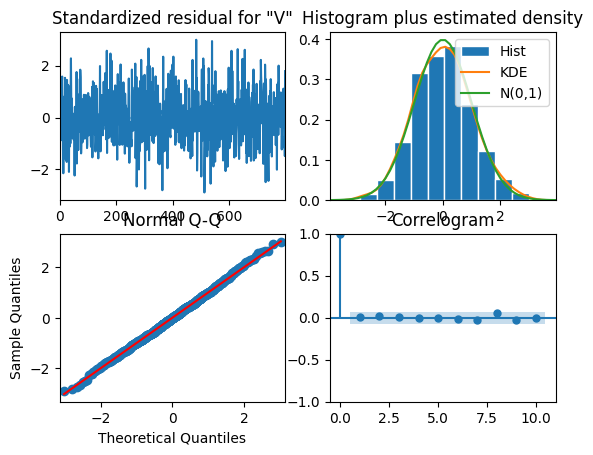

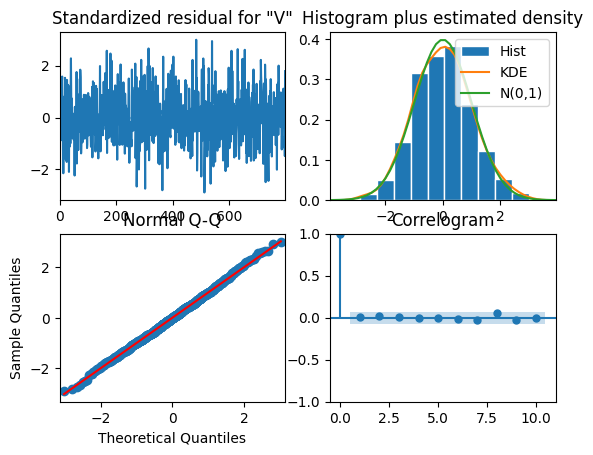

In [36]:
model.plot_diagnostics()

In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = model.resid
acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,0.056275,0.812484
2,0.328614,0.848482
3,0.453365,0.929011
4,0.454129,0.977810
5,0.481361,0.992790
6,0.561697,0.997005
7,1.416767,0.985052
8,3.826237,0.872451
9,4.239480,0.894955
10,4.239481,0.935898
